# 1. Loading sentence bert

In [1]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from scipy.spatial.distance import cosine

# model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')
model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
# model = SentenceTransformer('all-mpnet-base-v2')

# 2. Loading data

In [2]:
import pandas as pd
from os import path

df_train = pd.read_csv(path.join('data', 'train.csv'), delimiter='\t')
df_val = pd.read_csv(path.join('data', 'dev.csv'), delimiter='\t')
df_sample_test = pd.read_csv(path.join('data', 'sample_demo.csv'), delimiter='\t')

for df in [df_train, df_val, df_sample_test]:
    if 'setence1' in df.columns:
        df.rename(columns={'setence1': 'sentence1'}, inplace=True)
    df['sentence1']= df['sentence1'].astype(str)
    df['sentence2']= df['sentence2'].astype(str)

df_train = df_train[['sentence1', 'sentence2', 'score']] # Reorder columns
df_val = df_val[['sentence1', 'sentence2', 'score']]
df_sample_test = df_sample_test[['sentence1', 'sentence2', 'score']]

df_train

,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25
...,...,...,...
5706,Severe Gales As Storm Clodagh Hits Britain,Merkel pledges NATO solidarity with Latvia,0.00
5707,Dozens of Egyptians hostages taken by Libyan t...,Egyptian boat crash death toll rises as more b...,0.00
5708,President heading to Bahrain,President Xi: China to continue help to fight ...,0.00
5709,"China, India vow to further bilateral ties",China Scrambles to Reassure Jittery Stock Traders,0.00


In [3]:
train_data = [
    InputExample(texts=[sentence_1, sentence_2], label=score/5)
    for _, (sentence_1, sentence_2, score) in df_train.iterrows()
]
val_data = [
    InputExample(texts=[sentence_1, sentence_2], label=score/5)
    for _, (sentence_1, sentence_2, score) in df_val.iterrows()
]

train_dataset = SentencesDataset(train_data, model)
val_dataset = SentencesDataset(val_data, model)

# 3. Training

In [4]:
from torch.utils.data import DataLoader
import torch

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
loss_fn = losses.CosineSimilarityLoss(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Loss history acquired with the help of official sentence-transformer codebase https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/CosineSimilarityLoss.py

In [5]:
import sentence_transformers
from sentence_transformers import evaluation
from tqdm import tqdm

model.to(device)
epochs = 30

history = {
    'train_loss': [],
    'val_loss': []
}

for epoch in tqdm(range(epochs)):
    model.train()
    model.fit(train_objectives=[(train_dataloader, loss_fn)], show_progress_bar=False)

    model.eval()
    for key, df in zip(['train', 'val'], [df_train, df_val]):
        embeddings_col_1 = torch.tensor(model.encode(df.sentence1))
        embeddings_col_2 = torch.tensor(model.encode(df.sentence2))
        
        output = torch.cosine_similarity(embeddings_col_1, embeddings_col_2)
        loss = loss_fn.loss_fct(output, torch.tensor(df['score']/5).view(-1))
        history[f'{key}_loss'].append(float(loss))

pd.DataFrame(history)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [06:04<00:00, 12.15s/it]


,train_loss,val_loss
0,0.034134,0.028884
1,0.033020,0.028196
2,0.032132,0.027665
3,0.031328,0.027196
4,0.030720,0.026866
5,0.030213,0.026606
6,0.029688,0.026327
7,0.029193,0.026071
8,0.028772,0.025873
9,0.028425,0.025715


In [6]:
model.save("model-task-1c")

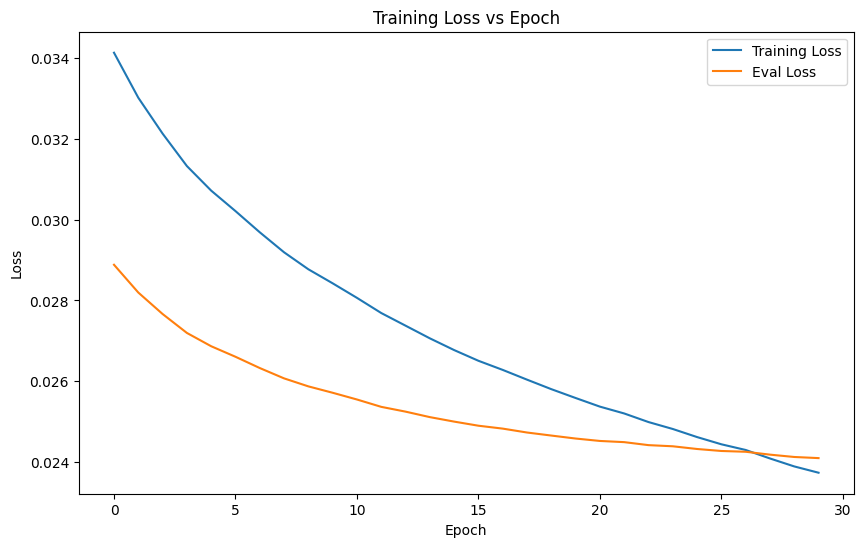

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(list(range(epochs)),  history['train_loss'], label='Training Loss')
plt.plot(list(range(epochs)),  history['val_loss'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

# 4. Evaluation metric

In [8]:
import numpy as np

model = SentenceTransformer("model-task-1c")
df = df_val.copy()
embeddings_col_1 = model.encode(df.sentence1, show_progress_bar=True)
embeddings_col_2 = model.encode(df.sentence2, show_progress_bar=True)

predictions = []

for embedding_1, embedding_2 in zip(embeddings_col_1, embeddings_col_2):
    cos_distance = cosine(embedding_1, embedding_2)
    cos_similarity = 1-cos_distance
    similarity_scaled = np.clip(cos_similarity * 5, 0, 5)
    predictions.append(round(similarity_scaled, 2))

df['prediction'] = predictions
df

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

,sentence1,sentence2,score,prediction
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00,4.94
1,A young child is riding a horse.,A child is riding a horse.,4.75,4.89
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00,4.94
3,A woman is playing the guitar.,A man is playing guitar.,2.40,3.31
4,A woman is playing the flute.,A man is playing a flute.,2.75,3.98
...,...,...,...,...
1465,Scientists prove there is water on Mars,Has Nasa discovered water on Mars?,2.00,4.11
1466,Pranab stresses need to strive for peace by na...,WTO: India regrets action of developed nations,0.00,1.76
1467,Volkswagen skids into red in wake of pollution...,"Volkswagen's ""gesture of goodwill"" to diesel o...",2.00,1.84
1468,Obama is right: Africa deserves better leadership,Obama waiting for midterm to name attorney gen...,0.00,0.86


In [9]:
df.describe()

,score,prediction
count,1470.000000,1470.000000
mean,2.344035,2.605048
std,1.502124,1.415201
min,0.000000,0.000000
25%,1.000000,1.442500
50%,2.400000,2.755000
75%,3.600000,3.800000
max,5.000000,5.000000


### 4.1. Pearson correlation on validation set

In [10]:
import evaluate

pearsonr_metric = evaluate.load("pearsonr")
results = pearsonr_metric.compute(predictions=df['prediction'], references=df['score'])
print("Pearson correlation:", round(results['pearsonr'], 3))

Pearson correlation: 0.878


# 5. Sample outputs on sample_test.csv

Useful for eyeballing

In [11]:
import numpy as np

df = df_sample_test.copy()
embeddings_col_1 = model.encode(df.sentence1, show_progress_bar=True)
embeddings_col_2 = model.encode(df.sentence2, show_progress_bar=True)

predictions = []

for embedding_1, embedding_2 in zip(embeddings_col_1, embeddings_col_2):
    cos_distance = cosine(embedding_1, embedding_2)
    cos_similarity = 1-cos_distance
    similarity_scaled = np.clip(cos_similarity * 5, 0, 5)
    predictions.append(round(similarity_scaled, 2))

df['prediction'] = predictions
df

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,sentence1,sentence2,score,prediction
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.000,4.94
1,A young child is riding a horse.,A child is riding a horse.,4.750,4.89
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.000,4.94
3,A woman is playing the guitar.,A man is playing guitar.,2.400,3.31
4,A woman is playing the flute.,A man is playing a flute.,2.750,3.98
5,A woman is cutting an onion.,A man is cutting onions.,2.615,3.47
